Notebook used to generate data for alldots.ipynb

In [1]:
import glob
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import BootstrapFunctions as bsf

In [2]:
standard_columns = ['E[rhoxy]','E[CVx/CVy]','E[<x>]','E[<y>]','E[<F_x>]','E[<F_y>]',
                    '97.5% (rhoxy)','2.5% (rhoxy)','97.5% (CVx/CVy)','2.5% (CVx/CVy)',
                    '97.5% (<x>)','2.5% (<x>)','97.5% (<y>)','2.5% (<y>)',
                    '97.5% (<F_x>)','2.5% (<F_x>)','97.5% (<F_y>)','2.5% (<F_y>)',
                    'F_y at avg','F_x at avg','Var[lambda]','Var[gamma]','E[lambda]','E[gamma]',
                    'consistent fy signs (avg)','consistent fy signs (at avg)',
                    'consistent fx signs (avg)','consistent fx signs (at avg)']
parentfolders = ['splitoffset']

In [3]:
paramlist = ['lambda','beta_x','gamma','beta_y','nx','Kx','ny','Ky','offset']
byfilelist = ['fileN','fileda','filedb','sysname']

In [4]:
#List out the perturbation types: u is up, d is down, n is none. l for lambda, g for gamma.  Add 1,2 to balance the neutral points
pertcases = {"lngn":[0,1,2],"lngu":[3,4,5],"lngd":[6,7,8],
             "lugn":[9,10,11],"lugu":[12,13,14],"lugd":[15,16,17],
             "ldgn":[18,19,20],"ldgu":[21,22,23],"ldgd":[24,25,26]}
oneparamperts = pertcases["lngn"]+pertcases["lugn"]+pertcases["ldgn"]+pertcases["lngu"]+pertcases["lngd"]
no_nonperts = pertcases["lugn"]+pertcases["ldgn"]+pertcases["lngu"]+pertcases["lngd"]

In [5]:
def rate(x,y,l,nx,Kx,ny,Ky,o):
    return l*((x**nx)/(Kx**nx+x**nx) + (y**ny)/(Ky**ny+y**ny)) + o
def rate_deriv_x(x,y,l,nx,Kx,ny,Ky,o):
    return l*nx*(x**(nx-1))*(Kx**nx)/(Kx**nx+x**nx)**2
def rate_deriv_y(x,y,l,nx,Kx,ny,Ky,o):
    return l*ny*(y**(ny-1))*(Ky**ny)/(Ky**ny+y**ny)**2
def sensitivty_x(x,y,l,nx,Kx,ny,Ky,o):
    return x*rate_deriv_x(x,y,l,nx,Kx,ny,Ky,o)/rate(x,y,l,nx,Kx,ny,Ky,o)
def sensitivty_y(x,y,l,nx,Kx,ny,Ky,o):
    return y*rate_deriv_y(x,y,l,nx,Kx,ny,Ky,o)/rate(x,y,l,nx,Kx,ny,Ky,o)

In [6]:
no_feedback_no_int = []
just_mrna_feedback = []
just_protein_feedback = []
both_feedback = []
names = ['2D_no_feedback_split','2D_just_mrna_feedback_split','2D_just_protein_feedback_split','2D_both_feedback_split']

In [8]:
#For sorting data to display parameters
for parent in parentfolders:
    folders = glob.glob(f'Data/{parent}/*/*')
    dat = []
    failedsims = []
    bootstrapdicts = []
    for i,folder in enumerate(folders):
        files = glob.glob(folder+'/*data.csv',recursive=True)
        for j,f in enumerate(files):
            data = pd.read_csv(f)
            data = data.reset_index().rename(columns={'index':'perturbation'})
            numstrings = f.split("_")[-2].split('n')
            if (data[['Cov Bal xx','Cov Bal yy','Cov Bal xy']] > 0.05).any(axis=1).any():
                failedsims.append(f)
                continue
            data['fileN'] = float(numstrings[0])
            data['fileda'] = float(numstrings[1])
            data['filedb'] = float(numstrings[2])
            data['sysname'] = "/".join(f.split("/")[:-1])
            if 'offset' not in data:
                data['offset'] = 0
            dat.append(data)
            bsdict = bsf.pertexp_interpret(data,'all')
            fys = sensitivty_y(data['<x>'].astype(float),data['<y>'].astype(float),
                                            data['lambda'],data['nx'].astype(float),data['Kx'],
                                            data['ny'].astype(float),data['Ky'],data['offset'])
            fxs = sensitivty_x(data['<x>'].astype(float),data['<y>'].astype(float),
                                            data['lambda'],data['nx'].astype(float),data['Kx'],
                                            data['ny'].astype(float),data['Ky'],data['offset'])
            bsdict['F_y at avg'] = fys.mean()
            bsdict['F_x at avg'] = fxs.mean()
            bsdict['consistent fy signs (avg)'] = np.sum(np.sign(data['<F_y>']))
            bsdict['consistent fx signs (avg)'] = np.sum(np.sign(1-data['<F_x>']))
            bsdict['consistent fy signs (at avg)'] = np.sum(np.sign(fys))
            bsdict['consistent fx signs (at avg)'] = np.sum(np.sign(1-fxs))
            bsdict['fileN'] = float(numstrings[0])
            bsdict['fileda'] = float(numstrings[1])
            bsdict['filedb'] = float(numstrings[2])
            bsdict['sysname'] = "/".join(f.split("/")[:-1])
            for p in paramlist:
                try:
                    bsdict[p] = data[p][0]
                except KeyError:
                    bsdict[p] = 0
            if data['nx'][0] == 0 and data['ny'][0] == 0:
                if bsdict['offset'] != 0:
                    bsdict['lambda'] *= bsdict['offset']
                    bsdict['offset'] = 0
                no_feedback_no_int.append(bsdict)
            elif data['nx'][0] != 0 and data['ny'][0] == 0:
                just_mrna_feedback.append(bsdict)
            elif data['nx'][0] == 0 and data['ny'][0] != 0:
                just_protein_feedback.append(bsdict)
            else:
                both_feedback.append(bsdict)
    print(f"Finished {parent}")
for i,dataset in enumerate([no_feedback_no_int,just_mrna_feedback,just_protein_feedback,both_feedback]):
    if len(dataset) == 0:
        continue
    df = pd.DataFrame(dataset)
    df.set_index(['fileN','fileda','filedb','sysname'],inplace=True)
    df[paramlist+['E[<F_x>]','E[<F_y>]','F_y at avg','F_x at avg','consistent fy signs (avg)','consistent fx signs (avg)',
                  'consistent fy signs (at avg)','consistent fx signs (at avg)']].to_csv(f'Data/parameters/{names[i]}.csv')

Finished splitoffset


In [54]:
pairedparams = ['lambda','beta_x','gamma','beta_y','Ky','offset']

In [41]:
bootstrapped_res[pairedparams].value_counts().to_latex('test.tex',float_format="%.2f")

In [40]:
bootstrapped_res[pairedparams].dtypes

lambda    float64
beta_x      int64
gamma     float64
beta_y      int64
Ky          int64
dtype: object

In [52]:
def f2(x):
        return f"%.{2}f" % x

def f5(x):
    return f"%.{5}f" % x

formatters = {'lambda':f2,'gamma':f2}

bootstrapped_res[pairedparams].value_counts().to_latex('test.tex',formatters=formatters)

In [ ]:
bootstrapped_res['strlambda'] = bootstrapped_res['lambda'].apply(f2)
bootstrapped_res['strgamma'] = bootstrapped_res['gamma'].apply(f2)

pairedparams = ['strlambda','beta_x','strgamma','beta_y','Ky','offset']
bootstrapped_res[pairedparams].value_counts().to_latex('test.tex',float_format="%.2f")

array([[<Axes: title={'center': 'lambda'}>,
        <Axes: title={'center': 'beta_x'}>,
        <Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'beta_y'}>,
        <Axes: title={'center': 'Ky'}>]], dtype=object)

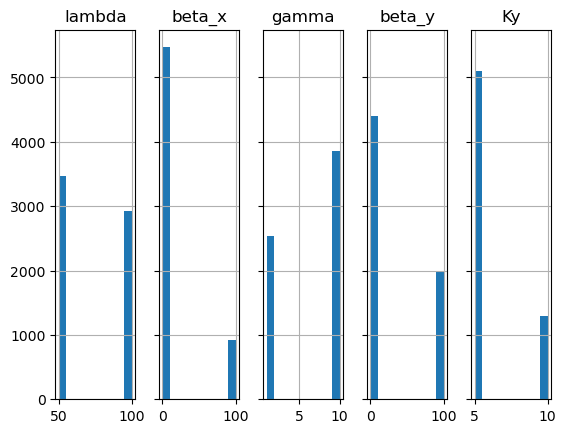

In [57]:
bootstrapped_res[pairedparams].hist(sharey=True,layout=(1,5))

array([[<Axes: title={'center': 'fileda'}>]], dtype=object)

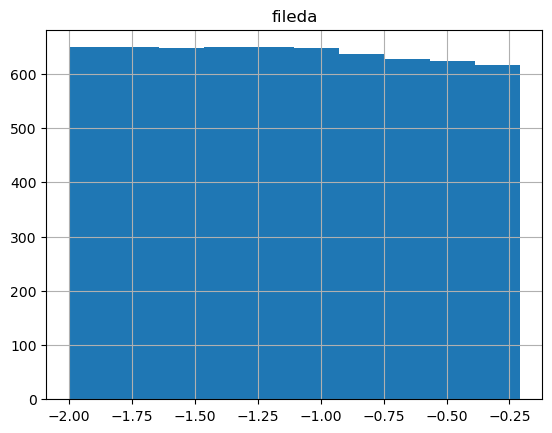

In [67]:
np.log10(bootstrapped_res.index.get_level_values('fileda').to_frame()).hist()

array([[<Axes: title={'center': 'filedb'}>]], dtype=object)

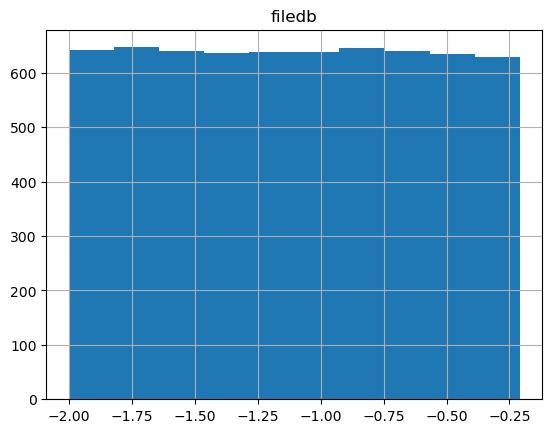

In [66]:
np.log10(bootstrapped_res.index.get_level_values('filedb').to_frame()).hist()

array([[<Axes: title={'center': 'fileN'}>]], dtype=object)

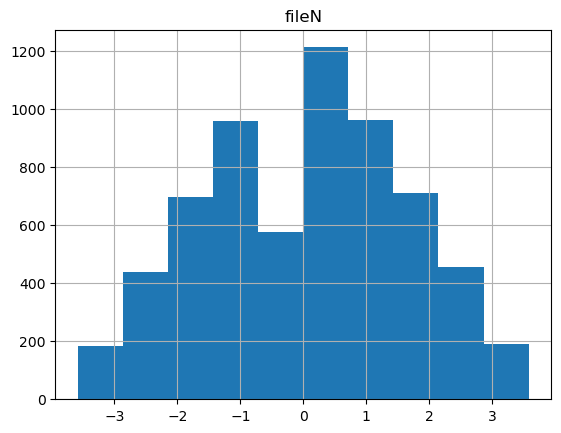

In [65]:
np.log10(bootstrapped_res.index.get_level_values('fileN').to_frame()).hist()

In [75]:
bootstrapped_res[paramlist]['ny'].value_counts()

ny
1    6394
Name: count, dtype: int64